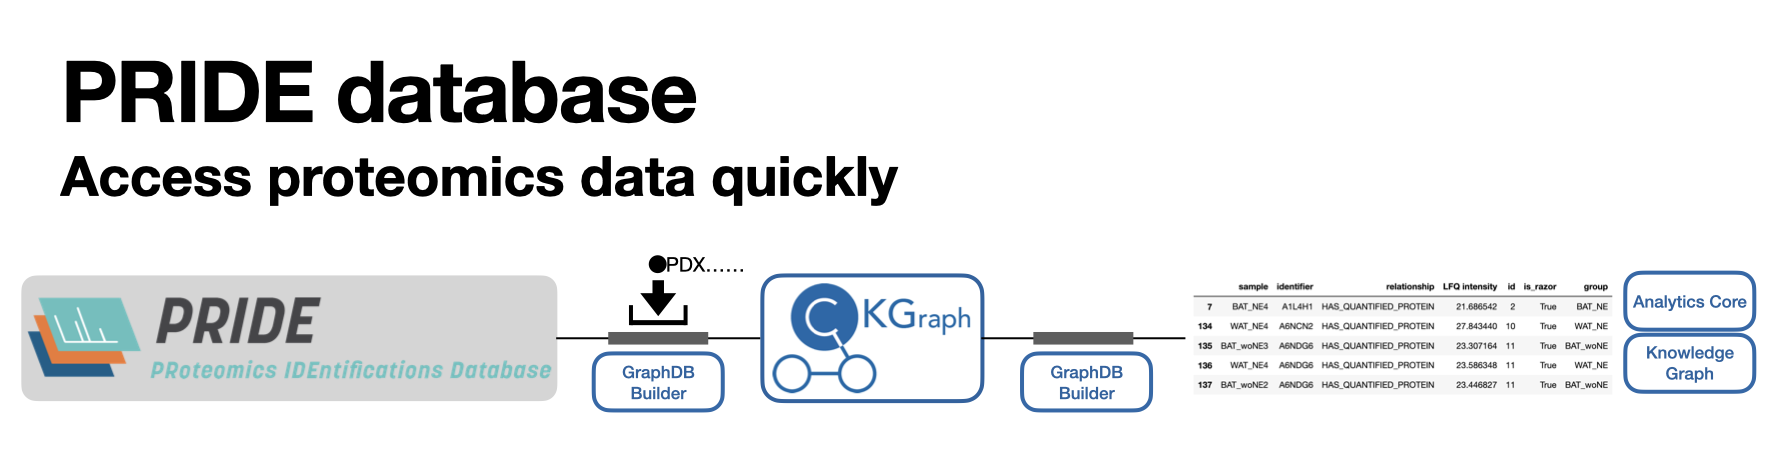


This notebook shows how **CKG** can be used to download data from the Proteomics Identifications Database - PRIDE - (https://www.ebi.ac.uk/pride/) and quickly formated to start analyzing them with the functionality in the analytics core.





In [2]:
import os

import ckg.ckg_utils as ckg_utils
from ckg.graphdb_builder import builder_utils
from ckg.graphdb_builder.experiments.parsers import proteomicsParser

from ckg.analytics_core.analytics import analytics

##### CKG path

In [3]:
ckg_location = '/Users/albertosantos/Development/Clinical_Proteomics_Department/ClinicalKnowledgeGraph(CKG)/code'

#### Define where the data should be downloaded

In [4]:
analysis_dir = os.path.join(ckg_location, '/data/tmp/Deshmukh2019')
ckg_utils.checkDirectory(analysis_dir)

##### Specify the PRIDE identifier and file to be downloaded 

In [5]:
pxd_id = 'PXD008541'
file_name='SearchEngineResults_secretome.zip.rar'

##### Download data

We can use functionality in graphdb_builder to directly download data files from EBI's PRIDE database (https://www.ebi.ac.uk/pride/). For that you just need to specify the PRIDE identifier for the project (PXD...) and the name of the file to download. In this case, the project identifier is **PXD008541** and the file we will use is **SearchEngineResults_secretome.zip.rar**, a RAR compressed file with the output files from MaxQuant.

In [6]:
builder_utils.download_PRIDE_data(pxd_id=pxd_id, 
                                  file_name=file_name, 
                                  to=analysis_dir)

'publicationDate'


{'status': 'INTERNAL_SERVER_ERROR',
 'code': 500,
 'message': 'Internal Server Error: Could not open JPA EntityManager for transaction; nested exception is javax.persistence.PersistenceException: org.hibernate.exception.GenericJDBCException: Could not open connection',
 'developerMessage': 'Please report to pride-support@ebi.ac.uk',
 'moreInfoUrl': None,
 'throwable': None}

## Read Data In

### Decompress File

In [5]:
builder_utils.unrar(filepath=os.path.join(analysis_dir, file_name), to=analysis_dir)

The list of files within the compressed folder can be listed using the listDirectoryFiles functionality in gaphdb_builder.

In [6]:
builder_utils.listDirectoryFiles(analysis_dir)

['peptides.txt',
 'SearchEngineResults_secretome.zip.rar',
 'modificationSpecificPeptides.txt',
 'experimentalDesignTemplate.txt',
 'parameters.txt',
 'msms.txt',
 'proteinGroups.txt']

We use the proteinGroups file that contains the proteomics data processed using MaxQuant software.

In [7]:
proteinGroups_file = os.path.join(analysis_dir, 'proteinGroups.txt')

### Parse Contents

CKG has parsers for MaxQuant and Spectronaut output files. The default configuration needed to parse these files needs to be updated with the name of the columns containing the protein quantifications for each sample. Also, the default configuration can be adapted to the experiment by selected specific filters or removing non-used columns. For example, in this study the output file did not have columns: Score, Q-value, so we removed them from the configuration and the column 'Potential contaminant' was renamed to 'Contaminant' so we changed the name in the filters.

In [8]:
#d = pd.read_csv(proteinGroups_file, sep='\t')
#d.columns.tolist()

In [9]:
columns = ['LFQ intensity BAT_NE1',
           'LFQ intensity BAT_NE2',
           'LFQ intensity BAT_NE3',
           'LFQ intensity BAT_NE4',
           'LFQ intensity BAT_NE5',
           'LFQ intensity BAT_woNE1',
           'LFQ intensity BAT_woNE2',
           'LFQ intensity BAT_woNE3',
           'LFQ intensity BAT_woNE4',
           'LFQ intensity BAT_woNE5',
           'LFQ intensity WAT_NE1',
           'LFQ intensity WAT_NE2',
           'LFQ intensity WAT_NE3',
           'LFQ intensity WAT_NE4',
           'LFQ intensity WAT_NE5',
           'LFQ intensity WAT_woNE1',
           'LFQ intensity WAT_woNE2',
           'LFQ intensity WAT_woNE3',
           'LFQ intensity WAT_woNE4',
           'LFQ intensity WAT_woNE5', 
           'Contaminant']

In [10]:
configuration = proteomicsParser.update_configuration(data_type='proteins', 
                                                      processing_tool='maxquant', 
                                                      value_col='LFQ intensity', 
                                                      columns=columns, 
                                                      drop_cols=['Score', 'Q-value', 'Potential contaminant'],
                                                      filters=['Reverse', 'Only identified by site', 'Contaminant'])

In [11]:
configuration

{'columns': ['Majority protein IDs',
  'Razor + unique peptides',
  'id',
  'LFQ intensity \\w+_AS\\d+_?-?\\d*',
  'Intensity \\w+_AS\\d+_?-?\\d*',
  'Reverse',
  'Only identified by site',
  'is_razor',
  'LFQ intensity BAT_NE1',
  'LFQ intensity BAT_NE2',
  'LFQ intensity BAT_NE3',
  'LFQ intensity BAT_NE4',
  'LFQ intensity BAT_NE5',
  'LFQ intensity BAT_woNE1',
  'LFQ intensity BAT_woNE2',
  'LFQ intensity BAT_woNE3',
  'LFQ intensity BAT_woNE4',
  'LFQ intensity BAT_woNE5',
  'LFQ intensity WAT_NE1',
  'LFQ intensity WAT_NE2',
  'LFQ intensity WAT_NE3',
  'LFQ intensity WAT_NE4',
  'LFQ intensity WAT_NE5',
  'LFQ intensity WAT_woNE1',
  'LFQ intensity WAT_woNE2',
  'LFQ intensity WAT_woNE3',
  'LFQ intensity WAT_woNE4',
  'LFQ intensity WAT_woNE5',
  'Contaminant'],
 'generated_columns': ['is_razor'],
 'filters': ['Reverse', 'Only identified by site', 'Contaminant'],
 'proteinCol': 'Majority protein IDs',
 'contaminant_tag': 'CON__',
 'valueCol': 'LFQ intensity',
 'groupCol': 'id'

When we parse the data, we obtain a matrix in an edge list following CKG's graph format: sample, protein, realtionship_type, value, protein_group_id, is_razor

In [12]:
data = proteomicsParser.parser_from_file(proteinGroups_file, configuration=configuration, data_type='proteins', is_standard=False)[('proteins', 'w')]

/Users/albertosantos/Development/Clinical_Proteomics_Department/ClinicalKnowledgeGraph(CKG)/code/src/graphdb_builder/experiments/parsers/proteomicsParser.py:118: RuntimeWarning:

divide by zero encountered in log2



In [13]:
data.head()

,START_ID,END_ID,TYPE,value,id,is_razor
0,WAT_woNE5,A0AVL1,HAS_QUANTIFIED_PROTEIN,20.109423,0,False
1,WAT_woNE2,A1A441,HAS_QUANTIFIED_PROTEIN,23.658291,1,False
2,BAT_woNE3,A1A441,HAS_QUANTIFIED_PROTEIN,22.753054,1,False
3,WAT_woNE5,A1A441,HAS_QUANTIFIED_PROTEIN,23.363726,1,False
4,BAT_NE3,A1A441,HAS_QUANTIFIED_PROTEIN,23.317552,1,False


In [14]:
data.columns = ['sample', 'identifier', 'relationship', 'LFQ intensity', 'id', 'is_razor']

In [15]:
data.head()

,sample,identifier,relationship,LFQ intensity,id,is_razor
0,WAT_woNE5,A0AVL1,HAS_QUANTIFIED_PROTEIN,20.109423,0,False
1,WAT_woNE2,A1A441,HAS_QUANTIFIED_PROTEIN,23.658291,1,False
2,BAT_woNE3,A1A441,HAS_QUANTIFIED_PROTEIN,22.753054,1,False
3,WAT_woNE5,A1A441,HAS_QUANTIFIED_PROTEIN,23.363726,1,False
4,BAT_NE3,A1A441,HAS_QUANTIFIED_PROTEIN,23.317552,1,False


In [16]:
data.shape

(57470, 6)

In [17]:
data = data[data.is_razor]

In [18]:
data.shape

(17489, 6)

We can use the sample names to extract the group information: BAT_NE, WAT_NE, BAT_woNE, WAT_woNE

With this last column, we obtain the **original dataframe** used as starting point in CKG' analysis pipelines.

In [19]:
data['group'] = data['sample'].apply(lambda x: re.sub('\d', '', x))

In [20]:
data.head()

,sample,identifier,relationship,LFQ intensity,id,is_razor,group
7,BAT_NE4,A1L4H1,HAS_QUANTIFIED_PROTEIN,21.686542,2,True,BAT_NE
134,WAT_NE4,A6NCN2,HAS_QUANTIFIED_PROTEIN,27.843440,10,True,WAT_NE
135,BAT_woNE3,A6NDG6,HAS_QUANTIFIED_PROTEIN,23.307164,11,True,BAT_woNE
136,WAT_NE4,A6NDG6,HAS_QUANTIFIED_PROTEIN,23.586348,11,True,WAT_NE
137,BAT_woNE2,A6NDG6,HAS_QUANTIFIED_PROTEIN,23.446827,11,True,BAT_woNE


In [21]:
original = data[['group', 'sample', 'identifier', 'LFQ intensity']]

##### --> the original dataframe is the starting point in CKG's  proteomics analysis.

## Data Preparation

In order to prepare the data we follow the steps:

1) Filtering based on missing values

2) Imputation of missing values using a mixed model estrategy: KNN and MinProb

These steps will generate the **processed dataframe**, a complete matrix that can be used in the exploratory and statistical analysis.

In [28]:
processed_data = analytics.get_proteomics_measurements_ready(original, 
                                                             index_cols=['group', 'sample'], 
                                                             drop_cols=['sample'], 
                                                             group='group', 
                                                             identifier='identifier', 
                                                             extra_identifier=None, 
                                                             imputation=True, 
                                                             method='mixed',
                                                             knn_cutoff=0.4,
                                                             missing_method='at_least_x', 
                                                             missing_per_group=True, 
                                                             min_valid=3, 
                                                             value_col='LFQ intensity',
                                                             shift=1.8,
                                                             nstd=0.3)

In [29]:
processed_data.head()

identifier,group,sample,A6NDG6,B3KW70,E9PAV3,E9PGF5,E9PHK0,F5GWP8,F8W031,G3V3G9,...,Q9Y4Y9,Q9Y5P4,Q9Y5X3,Q9Y5Z4,Q9Y600,Q9Y617,Q9Y646,Q9Y678,Q9Y696,Q9Y6I3
0,BAT_NE,BAT_NE1,22.948430,29.091339,26.578739,23.563604,27.322081,27.821164,24.420405,23.947173,...,22.109509,23.130157,22.569201,28.647187,24.888146,26.012226,22.746304,23.610317,24.676053,23.408469
1,BAT_NE,BAT_NE2,22.954981,28.610591,27.468243,23.811590,26.283462,27.452462,23.071491,23.891354,...,22.109780,23.312665,22.572965,28.026016,24.164153,26.294796,22.171377,25.493292,24.928906,22.570449
2,BAT_NE,BAT_NE3,22.817377,28.272086,26.773793,23.708936,25.299149,27.471115,22.773441,23.618293,...,22.104088,23.378619,22.493896,27.956985,25.221587,26.440457,22.150598,25.144410,26.972790,22.340063
3,BAT_NE,BAT_NE4,22.937885,30.812377,26.089441,23.757766,28.160532,28.601127,23.301110,23.881631,...,22.109074,22.237510,22.563142,27.506049,24.793327,24.906694,22.693322,23.264133,25.210343,22.709766
4,BAT_NE,BAT_NE5,23.047168,28.364277,26.971255,24.055731,25.989885,26.889135,22.317248,24.034814,...,22.113593,23.397543,22.625936,28.196715,25.171234,26.397037,21.778724,24.573057,26.251168,22.132167
